# Lectura y preprocesamiento de las imagenes 

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, ResNet50, MobileNet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from collections import Counter

In [2]:
# Ruta del directorio que contiene las carpetas con imágenes
directorio_data = '/kaggle/input/corn-or-maize-leaf-disease-dataset/data'

# Listas para almacenar las imagenes (como matrices) y sus respectivas etiquetas
imagenes = []
etiquetas = []
tamanio_deseado = (150, 150)

# Diccionario para almacenar una imagen de cada clase
muestra_por_clase = {}

# Iterar sobre las carpetas (etiquetas)
for etiqueta in os.listdir(directorio_data):
    # Construir la ruta completa de la carpeta de la etiqueta
    carpeta_etiqueta = os.path.join(directorio_data, etiqueta)
    
    # Verificar si es un directorio
    if os.path.isdir(carpeta_etiqueta):
        # Iterar sobre los archivos en la carpeta
        for nombre_archivo in os.listdir(carpeta_etiqueta):
            # Construir la ruta completa del archivo
            ruta_archivo = os.path.join(carpeta_etiqueta, nombre_archivo)
            
            # Leer la imagen con OpenCV y redimensionarla al tamaño deseado
            imagen = cv2.imread(ruta_archivo, cv2.IMREAD_COLOR)
            imagen = cv2.resize(imagen, tamanio_deseado)
            
            # Normalizar los valores de píxeles (escala de 0 a 1)
            imagen = imagen / 255.0
            
            # Agregar la imagen y la etiqueta a las listas
            imagenes.append(imagen)
            etiquetas.append(etiqueta)
            
            # Guardar una muestra de cada clase
            if etiqueta not in muestra_por_clase:
                muestra_por_clase[etiqueta] = imagen

# Convertir las listas a matrices numpy
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

# Convertir etiquetas de texto a valores numéricos usando LabelEncoder
label_encoder = LabelEncoder()
etiquetas_numericas = label_encoder.fit_transform(etiquetas)

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(imagenes, etiquetas_numericas, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convertir las etiquetas a formato categórico
num_clases = len(np.unique(etiquetas_numericas))
y_train = to_categorical(y_train, num_clases)
y_val = to_categorical(y_val, num_clases)
y_test = to_categorical(y_test, num_clases)

# Convertir los conjuntos de datos a tipo float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Imprimir las formas de los conjuntos de entrenamiento, validación y prueba
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (2931, 150, 150, 3)
Forma de X_val: (628, 150, 150, 3)
Forma de X_test: (629, 150, 150, 3)
Forma de y_train: (2931, 4)
Forma de y_val: (628, 4)
Forma de y_test: (629, 4)


# Transfer Learning con ResNet

In [9]:
# Definir tasas de aprendizaje
learning_rates = [0.001, 0.01, 0.1]

# Inicializar la búsqueda en la cuadrícula
best_lr = None
best_accuracy = 0
accuracies_per_lr = []

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Iterar sobre las tasas de aprendizaje
for lr in learning_rates:
    # Crear el modelo
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_clases, activation='softmax')
    ])

    # Compilar el modelo con la tasa de aprendizaje actual
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                     epochs=10,
                     validation_data=(X_val, y_val),
                     steps_per_epoch=len(X_train) // 32,
                     verbose=2)

    # Evaluar el modelo en el conjunto de validación
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f'Learning Rate: {lr} - Validation Accuracy: {scores[1]}')
    
    # Guardar los resultados
    accuracies_per_lr.append((lr, scores[1]))

    # Actualizar la mejor tasa de aprendizaje
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_lr = lr

print(f'Best Learning Rate: {best_lr} with Validation Accuracy: {best_accuracy}')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


W0000 00:00:1719375921.173587     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 40s - 435ms/step - accuracy: 0.6733 - loss: 0.8243 - val_accuracy: 0.4904 - val_loss: 1.1865
Epoch 2/10


W0000 00:00:1719375947.003233     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 1s - 7ms/step - accuracy: 0.5312 - loss: 0.9777 - val_accuracy: 0.4363 - val_loss: 1.1695
Epoch 3/10
91/91 - 14s - 154ms/step - accuracy: 0.7196 - loss: 0.7207 - val_accuracy: 0.5653 - val_loss: 1.4315
Epoch 4/10
91/91 - 1s - 7ms/step - accuracy: 0.7188 - loss: 0.6757 - val_accuracy: 0.5685 - val_loss: 1.4335
Epoch 5/10
91/91 - 14s - 157ms/step - accuracy: 0.7613 - loss: 0.6470 - val_accuracy: 0.5605 - val_loss: 1.1402
Epoch 6/10
91/91 - 1s - 7ms/step - accuracy: 0.6875 - loss: 0.8095 - val_accuracy: 0.5557 - val_loss: 1.1608
Epoch 7/10
91/91 - 14s - 155ms/step - accuracy: 0.7644 - loss: 0.6114 - val_accuracy: 0.4427 - val_loss: 1.9974
Epoch 8/10
91/91 - 1s - 7ms/step - accuracy: 0.7812 - loss: 0.7234 - val_accuracy: 0.4315 - val_loss: 2.2373
Epoch 9/10
91/91 - 14s - 155ms/step - accuracy: 0.7827 - loss: 0.6135 - val_accuracy: 0.3376 - val_loss: 5.1899
Epoch 10/10
91/91 - 1s - 6ms/step - accuracy: 0.7500 - loss: 0.7022 - val_accuracy: 0.3376 - val_loss: 4.8691
Learning Rate: 0.

W0000 00:00:1719376035.141952     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 34s - 372ms/step - accuracy: 0.6613 - loss: 0.9399 - val_accuracy: 0.2532 - val_loss: 3.9742
Epoch 2/10


W0000 00:00:1719376043.451527     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 1s - 7ms/step - accuracy: 0.5938 - loss: 1.1766 - val_accuracy: 0.2548 - val_loss: 4.1311
Epoch 3/10
91/91 - 14s - 155ms/step - accuracy: 0.7182 - loss: 0.7631 - val_accuracy: 0.3854 - val_loss: 3.8097
Epoch 4/10
91/91 - 1s - 6ms/step - accuracy: 0.6250 - loss: 0.8136 - val_accuracy: 0.3360 - val_loss: 4.6137
Epoch 5/10
91/91 - 14s - 154ms/step - accuracy: 0.7444 - loss: 0.6806 - val_accuracy: 0.3774 - val_loss: 7.2297
Epoch 6/10
91/91 - 1s - 7ms/step - accuracy: 0.7812 - loss: 0.4870 - val_accuracy: 0.3232 - val_loss: 8.0788
Epoch 7/10
91/91 - 14s - 155ms/step - accuracy: 0.7527 - loss: 0.6712 - val_accuracy: 0.5016 - val_loss: 1.0442
Epoch 8/10
91/91 - 1s - 6ms/step - accuracy: 0.7188 - loss: 0.5507 - val_accuracy: 0.4857 - val_loss: 1.1805
Epoch 9/10
91/91 - 14s - 154ms/step - accuracy: 0.7665 - loss: 0.6427 - val_accuracy: 0.3073 - val_loss: 7.4555
Epoch 10/10
91/91 - 1s - 7ms/step - accuracy: 0.7188 - loss: 0.5874 - val_accuracy: 0.3280 - val_loss: 6.0869
Learning Rate: 0.

W0000 00:00:1719376125.571722     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 34s - 370ms/step - accuracy: 0.5323 - loss: 2.0900 - val_accuracy: 0.3344 - val_loss: 30.1906
Epoch 2/10


W0000 00:00:1719376138.560239     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 1s - 7ms/step - accuracy: 0.7188 - loss: 0.6958 - val_accuracy: 0.3344 - val_loss: 34.2736
Epoch 3/10
91/91 - 14s - 154ms/step - accuracy: 0.6195 - loss: 1.1206 - val_accuracy: 0.3917 - val_loss: 3.6199
Epoch 4/10
91/91 - 1s - 6ms/step - accuracy: 0.6316 - loss: 1.1356 - val_accuracy: 0.3344 - val_loss: 5.4706
Epoch 5/10
91/91 - 14s - 157ms/step - accuracy: 0.6792 - loss: 0.9229 - val_accuracy: 0.3933 - val_loss: 2.3834
Epoch 6/10
91/91 - 1s - 6ms/step - accuracy: 0.5938 - loss: 0.9130 - val_accuracy: 0.3487 - val_loss: 3.6435
Epoch 7/10
91/91 - 14s - 154ms/step - accuracy: 0.6840 - loss: 0.8872 - val_accuracy: 0.4538 - val_loss: 7.8031
Epoch 8/10
91/91 - 1s - 6ms/step - accuracy: 0.8438 - loss: 0.4659 - val_accuracy: 0.4076 - val_loss: 8.5730
Epoch 9/10
91/91 - 14s - 155ms/step - accuracy: 0.6709 - loss: 1.0606 - val_accuracy: 0.3838 - val_loss: 11.5097
Epoch 10/10
91/91 - 1s - 6ms/step - accuracy: 0.6250 - loss: 1.2422 - val_accuracy: 0.3455 - val_loss: 15.7784
Learning Rate:

### Ejecutando el modelo ResNet

In [10]:
# Crear el modelo con la mejor tasa de aprendizaje
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_clases, activation='softmax')
])

# Compilar el modelo con la mejor tasa de aprendizaje
optimizer = Adam(learning_rate=best_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Definir el programador de tasa de aprendizaje
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: best_lr * 0.8 ** (epoch // 7))

# Entrenar el modelo en todo el conjunto de entrenamiento
hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                 epochs=50,
                 validation_data=(X_val, y_val),
                 steps_per_epoch=len(X_train) // 32,
                 verbose=2,
                 callbacks=[lr_scheduler])

Epoch 1/50


W0000 00:00:1719376218.564235     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 35s - 385ms/step - accuracy: 0.5540 - loss: 2.0615 - val_accuracy: 0.3344 - val_loss: 71.8427 - learning_rate: 0.1000
Epoch 2/50


W0000 00:00:1719376235.360054     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 1s - 7ms/step - accuracy: 0.7188 - loss: 1.1543 - val_accuracy: 0.3344 - val_loss: 64.7092 - learning_rate: 0.1000
Epoch 3/50
91/91 - 14s - 154ms/step - accuracy: 0.6502 - loss: 1.0940 - val_accuracy: 0.3344 - val_loss: 18.9177 - learning_rate: 0.1000
Epoch 4/50
91/91 - 1s - 7ms/step - accuracy: 0.7500 - loss: 0.5767 - val_accuracy: 0.3360 - val_loss: 16.4847 - learning_rate: 0.1000
Epoch 5/50
91/91 - 14s - 156ms/step - accuracy: 0.6916 - loss: 0.8910 - val_accuracy: 0.5844 - val_loss: 1.4935 - learning_rate: 0.1000
Epoch 6/50
91/91 - 1s - 6ms/step - accuracy: 0.8438 - loss: 0.4842 - val_accuracy: 0.5685 - val_loss: 1.4327 - learning_rate: 0.1000
Epoch 7/50
91/91 - 14s - 153ms/step - accuracy: 0.6654 - loss: 1.0487 - val_accuracy: 0.3217 - val_loss: 10.5350 - learning_rate: 0.1000
Epoch 8/50
91/91 - 1s - 7ms/step - accuracy: 0.6562 - loss: 0.5410 - val_accuracy: 0.3344 - val_loss: 9.5554 - learning_rate: 0.0800
Epoch 9/50
91/91 - 14s - 156ms/step - accuracy: 0.6737 - loss: 0.99

In [12]:
# Evaluar el modelo en el conjunto de prueba
test_scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy with Best Learning Rate ({best_lr}): {test_scores[1]}')
print(f'Test Loss with Best Learning Rate ({best_lr}): {test_scores[0]}')

Test Accuracy with Best Learning Rate (0.1): 0.5882353186607361
Test Loss with Best Learning Rate (0.1): 2.17093825340271


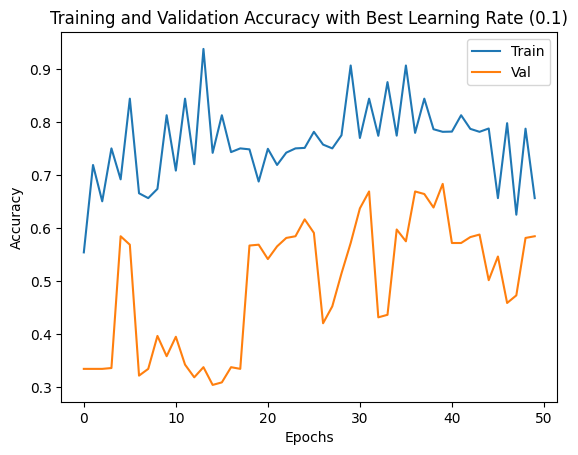

In [13]:
# Imprimir los resultados y generar la gráfica
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Val')
plt.title(f'Training and Validation Accuracy with Best Learning Rate ({best_lr})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Transfer Learning con MobileNet

In [14]:
# Definir tasas de aprendizaje
learning_rates = [0.001, 0.01, 0.1]

# Inicializar la búsqueda en la cuadrícula
best_lr = None
best_accuracy = 0
accuracies_per_lr = []

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Iterar sobre las tasas de aprendizaje
for lr in learning_rates:
    # Crear el modelo
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_clases, activation='softmax')
    ])

    # Compilar el modelo con la tasa de aprendizaje actual
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                     epochs=10,
                     validation_data=(X_val, y_val),
                     steps_per_epoch=len(X_train) // 32,
                     verbose=2)

    # Evaluar el modelo en el conjunto de validación
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f'Learning Rate: {lr} - Validation Accuracy: {scores[1]}')
    
    # Guardar los resultados
    accuracies_per_lr.append((lr, scores[1]))

    # Actualizar la mejor tasa de aprendizaje
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_lr = lr

print(f'Best Learning Rate: {best_lr} with Validation Accuracy: {best_accuracy}')

/tmp/ipykernel_34/3971569640.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


W0000 00:00:1719376601.106516     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 29s - 314ms/step - accuracy: 0.8386 - loss: 0.4917 - val_accuracy: 0.8885 - val_loss: 0.3734
Epoch 2/10
91/91 - 0s - 3ms/step - accuracy: 1.0000 - loss: 0.0384 - val_accuracy: 0.8901 - val_loss: 0.3708
Epoch 3/10
91/91 - 14s - 149ms/step - accuracy: 0.8820 - loss: 0.3188 - val_accuracy: 0.8806 - val_loss: 0.3376
Epoch 4/10
91/91 - 0s - 3ms/step - accuracy: 0.7812 - loss: 0.6771 - val_accuracy: 0.8822 - val_loss: 0.3469
Epoch 5/10
91/91 - 13s - 147ms/step - accuracy: 0.8972 - loss: 0.2730 - val_accuracy: 0.8933 - val_loss: 0.2814
Epoch 6/10
91/91 - 0s - 3ms/step - accuracy: 0.9688 - loss: 0.0900 - val_accuracy: 0.8949 - val_loss: 0.2804
Epoch 7/10
91/91 - 13s - 147ms/step - accuracy: 0.9082 - loss: 0.2550 - val_accuracy: 0.8901 - val_loss: 0.2662
Epoch 8/10
91/91 - 0s - 3ms/step - accuracy: 0.9375 - loss: 0.1313 - val_accuracy: 0.8901 - val_loss: 0.2696
Epoch 9/10
91/91 - 13s - 147ms/step - accuracy: 0.9062 - loss: 0.2491 - val_accuracy: 0.8949 - val_loss: 0.2517
Epoch 10/10
91/

W0000 00:00:1719376684.254822     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 24s - 262ms/step - accuracy: 0.8386 - loss: 0.5193 - val_accuracy: 0.8646 - val_loss: 0.4684
Epoch 2/10
91/91 - 0s - 3ms/step - accuracy: 0.7500 - loss: 0.5004 - val_accuracy: 0.8726 - val_loss: 0.4469
Epoch 3/10
91/91 - 13s - 146ms/step - accuracy: 0.8800 - loss: 0.3451 - val_accuracy: 0.8376 - val_loss: 0.4978
Epoch 4/10
91/91 - 0s - 3ms/step - accuracy: 0.8750 - loss: 0.4852 - val_accuracy: 0.8376 - val_loss: 0.4978
Epoch 5/10
91/91 - 13s - 147ms/step - accuracy: 0.8765 - loss: 0.3495 - val_accuracy: 0.8694 - val_loss: 0.3997
Epoch 6/10
91/91 - 0s - 3ms/step - accuracy: 0.9375 - loss: 0.2403 - val_accuracy: 0.8726 - val_loss: 0.3786
Epoch 7/10
91/91 - 13s - 146ms/step - accuracy: 0.8831 - loss: 0.3052 - val_accuracy: 0.9013 - val_loss: 0.2626
Epoch 8/10
91/91 - 0s - 3ms/step - accuracy: 0.8438 - loss: 0.3686 - val_accuracy: 0.8997 - val_loss: 0.2657
Epoch 9/10
91/91 - 13s - 147ms/step - accuracy: 0.8844 - loss: 0.3049 - val_accuracy: 0.9029 - val_loss: 0.2772
Epoch 10/10
91/

W0000 00:00:1719376763.966181     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 24s - 268ms/step - accuracy: 0.7910 - loss: 2.3741 - val_accuracy: 0.7373 - val_loss: 3.9793
Epoch 2/10
91/91 - 0s - 3ms/step - accuracy: 0.9375 - loss: 0.3215 - val_accuracy: 0.7404 - val_loss: 3.7854
Epoch 3/10
91/91 - 13s - 147ms/step - accuracy: 0.8224 - loss: 1.4358 - val_accuracy: 0.8519 - val_loss: 0.9121
Epoch 4/10
91/91 - 0s - 3ms/step - accuracy: 0.7500 - loss: 2.0362 - val_accuracy: 0.8153 - val_loss: 1.4038
Epoch 5/10
91/91 - 13s - 146ms/step - accuracy: 0.8299 - loss: 1.1363 - val_accuracy: 0.8519 - val_loss: 0.8353
Epoch 6/10
91/91 - 0s - 3ms/step - accuracy: 0.7188 - loss: 1.8107 - val_accuracy: 0.8599 - val_loss: 0.7798
Epoch 7/10
91/91 - 13s - 146ms/step - accuracy: 0.8272 - loss: 1.1033 - val_accuracy: 0.8806 - val_loss: 0.5107
Epoch 8/10
91/91 - 0s - 3ms/step - accuracy: 0.8438 - loss: 0.4740 - val_accuracy: 0.8646 - val_loss: 0.5802
Epoch 9/10
91/91 - 13s - 147ms/step - accuracy: 0.8396 - loss: 0.9192 - val_accuracy: 0.8312 - val_loss: 1.1675
Epoch 10/10
91/

In [15]:
# Crear el modelo con la mejor tasa de aprendizaje
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_clases, activation='softmax')
])

# Compilar el modelo con la mejor tasa de aprendizaje
optimizer = Adam(learning_rate=best_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/tmp/ipykernel_34/1515284129.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [16]:
# Definir el programador de tasa de aprendizaje
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: best_lr * 0.8 ** (epoch // 7))

# Entrenar el modelo en todo el conjunto de entrenamiento
hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                 epochs=50,
                 validation_data=(X_val, y_val),
                 steps_per_epoch=len(X_train) // 32,
                 verbose=2,
                 callbacks=[lr_scheduler])

Epoch 1/50


W0000 00:00:1719376844.161553     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 24s - 265ms/step - accuracy: 0.8372 - loss: 0.4843 - val_accuracy: 0.7946 - val_loss: 1.0317 - learning_rate: 0.0100
Epoch 2/50
91/91 - 0s - 3ms/step - accuracy: 0.8438 - loss: 0.2611 - val_accuracy: 0.8201 - val_loss: 0.9083 - learning_rate: 0.0100
Epoch 3/50
91/91 - 13s - 147ms/step - accuracy: 0.8679 - loss: 0.3919 - val_accuracy: 0.8599 - val_loss: 0.4832 - learning_rate: 0.0100
Epoch 4/50
91/91 - 0s - 3ms/step - accuracy: 0.7812 - loss: 0.7747 - val_accuracy: 0.8694 - val_loss: 0.4363 - learning_rate: 0.0100
Epoch 5/50
91/91 - 13s - 147ms/step - accuracy: 0.8775 - loss: 0.3450 - val_accuracy: 0.9029 - val_loss: 0.2822 - learning_rate: 0.0100
Epoch 6/50
91/91 - 0s - 3ms/step - accuracy: 0.8750 - loss: 0.2623 - val_accuracy: 0.8965 - val_loss: 0.2947 - learning_rate: 0.0100
Epoch 7/50
91/91 - 13s - 145ms/step - accuracy: 0.8931 - loss: 0.2904 - val_accuracy: 0.8885 - val_loss: 0.2897 - learning_rate: 0.0100
Epoch 8/50
91/91 - 0s - 3ms/step - accuracy: 0.9062 - loss: 0.2030 -

In [17]:
# Evaluar el modelo en el conjunto de prueba
test_scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy with Best Learning Rate ({best_lr}): {test_scores[1]}')
print(f'Test Loss with Best Learning Rate ({best_lr}): {test_scores[0]}')

Test Accuracy with Best Learning Rate (0.01): 0.9220985770225525
Test Loss with Best Learning Rate (0.01): 0.19658298790454865


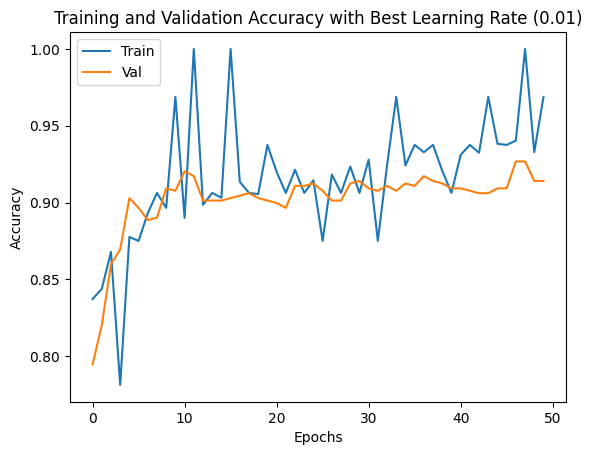

In [18]:
# Imprimir los resultados y generar la gráfica
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Val')
plt.title(f'Training and Validation Accuracy with Best Learning Rate ({best_lr})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Transfer Learning con DenseNet121

In [4]:
# Definir tasas de aprendizaje
learning_rates = [0.001, 0.01, 0.1]

# Inicializar la búsqueda en la cuadrícula
best_lr = None
best_accuracy = 0
accuracies_per_lr = []

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Iterar sobre las tasas de aprendizaje
for lr in learning_rates:
    # Crear el modelo
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_clases, activation='softmax')
    ])

    # Compilar el modelo con la tasa de aprendizaje actual
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                     epochs=10,
                     validation_data=(X_val, y_val),
                     steps_per_epoch=len(X_train) // 32,
                     verbose=2)

    # Evaluar el modelo en el conjunto de validación
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f'Learning Rate: {lr} - Validation Accuracy: {scores[1]}')
    
    # Guardar los resultados
    accuracies_per_lr.append((lr, scores[1]))

    # Actualizar la mejor tasa de aprendizaje
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_lr = lr

print(f'Best Learning Rate: {best_lr} with Validation Accuracy: {best_accuracy}')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1719374282.140236     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719374282.212643     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 81s - 886ms/step - accuracy: 0.8175 - loss: 0.5549 - val_accuracy: 0.8822 - val_loss: 0.3433
Epoch 2/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 - 1s - 7ms/step - accuracy: 0.8125 - loss: 0.8500 - val_accuracy: 0.8806 - val_loss: 0.3475
Epoch 3/10
91/91 - 14s - 156ms/step - accuracy: 0.8769 - loss: 0.3657 - val_accuracy: 0.8774 - val_loss: 0.3883
Epoch 4/10
91/91 - 1s - 7ms/step - accuracy: 0.8438 - loss: 0.4026 - val_accuracy: 0.8790 - val_loss: 0.4004
Epoch 5/10
91/91 - 14s - 157ms/step - accuracy: 0.8803 - loss: 0.3061 - val_accuracy: 0.8917 - val_loss: 0.3193
Epoch 6/10
91/91 - 1s - 7ms/step - accuracy: 0.8438 - loss: 0.4485 - val_accuracy: 0.8917 - val_loss: 0.3191
Epoch 7/10
91/91 - 14s - 155ms/step - accuracy: 0.8972 - loss: 0.2817 - val_accuracy: 0.8997 - val_loss: 0.2904
Epoch 8/10
91/91 - 1s - 7ms/step - accuracy: 0.9062 - loss: 0.2249 - val_accuracy: 0.9013 - val_loss: 0.2888
Epoch 9/10
91/91 - 14s - 156ms/step - accuracy: 0.8917 - loss: 0.2732 - val_accuracy: 0.9124 - val_loss: 0.2587
Epoch 10/10
91/91 - 1s - 7ms/step - accuracy: 0.9062 - loss: 0.1673 - val_accuracy: 0.9140 - val_loss: 0.2518
Learning Rate: 0.

W0000 00:00:1719374416.809202     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 56s - 618ms/step - accuracy: 0.8068 - loss: 0.5884 - val_accuracy: 0.6783 - val_loss: 1.7728
Epoch 2/10
91/91 - 1s - 7ms/step - accuracy: 0.9375 - loss: 0.1549 - val_accuracy: 0.6927 - val_loss: 1.5262
Epoch 3/10
91/91 - 14s - 157ms/step - accuracy: 0.8589 - loss: 0.3801 - val_accuracy: 0.8838 - val_loss: 0.3410
Epoch 4/10
91/91 - 1s - 7ms/step - accuracy: 0.9688 - loss: 0.2960 - val_accuracy: 0.8854 - val_loss: 0.3375
Epoch 5/10
91/91 - 14s - 158ms/step - accuracy: 0.8700 - loss: 0.3563 - val_accuracy: 0.8822 - val_loss: 0.3344
Epoch 6/10
91/91 - 1s - 7ms/step - accuracy: 0.7500 - loss: 0.5140 - val_accuracy: 0.8742 - val_loss: 0.3815
Epoch 7/10
91/91 - 14s - 158ms/step - accuracy: 0.8706 - loss: 0.3590 - val_accuracy: 0.8838 - val_loss: 0.3510
Epoch 8/10
91/91 - 1s - 7ms/step - accuracy: 0.8750 - loss: 0.2749 - val_accuracy: 0.8869 - val_loss: 0.3453
Epoch 9/10
91/91 - 14s - 157ms/step - accuracy: 0.8765 - loss: 0.3410 - val_accuracy: 0.8901 - val_loss: 0.3218
Epoch 10/10
91/

W0000 00:00:1719374537.010568     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 56s - 620ms/step - accuracy: 0.7537 - loss: 2.6339 - val_accuracy: 0.7452 - val_loss: 2.4333
Epoch 2/10
91/91 - 1s - 7ms/step - accuracy: 0.7188 - loss: 2.0777 - val_accuracy: 0.7452 - val_loss: 2.3726
Epoch 3/10
91/91 - 14s - 156ms/step - accuracy: 0.8044 - loss: 1.1670 - val_accuracy: 0.8790 - val_loss: 0.4892
Epoch 4/10
91/91 - 1s - 7ms/step - accuracy: 0.8125 - loss: 0.9220 - val_accuracy: 0.8774 - val_loss: 0.4880
Epoch 5/10
91/91 - 14s - 157ms/step - accuracy: 0.8203 - loss: 0.8250 - val_accuracy: 0.8471 - val_loss: 0.5234
Epoch 6/10
91/91 - 1s - 7ms/step - accuracy: 0.9688 - loss: 0.0810 - val_accuracy: 0.8710 - val_loss: 0.4575
Epoch 7/10
91/91 - 14s - 159ms/step - accuracy: 0.8396 - loss: 0.6344 - val_accuracy: 0.8742 - val_loss: 0.3921
Epoch 8/10
91/91 - 1s - 7ms/step - accuracy: 0.7812 - loss: 0.5198 - val_accuracy: 0.8662 - val_loss: 0.4508
Epoch 9/10
91/91 - 14s - 156ms/step - accuracy: 0.8344 - loss: 0.7124 - val_accuracy: 0.8758 - val_loss: 0.4262
Epoch 10/10
91/

### Ejecutando el modelo DenseNet121

In [5]:
# Crear el modelo con la mejor tasa de aprendizaje
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_clases, activation='softmax')
])

# Compilar el modelo con la mejor tasa de aprendizaje
optimizer = Adam(learning_rate=best_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Definir el programador de tasa de aprendizaje
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: best_lr * 0.8 ** (epoch // 7))

# Entrenar el modelo en todo el conjunto de entrenamiento
hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                 epochs=50,
                 validation_data=(X_val, y_val),
                 steps_per_epoch=len(X_train) // 32,
                 verbose=2,
                 callbacks=[lr_scheduler])

Epoch 1/50


W0000 00:00:1719374657.271590     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 - 57s - 631ms/step - accuracy: 0.8158 - loss: 0.5391 - val_accuracy: 0.8822 - val_loss: 0.2891 - learning_rate: 0.0010
Epoch 2/50
91/91 - 1s - 7ms/step - accuracy: 0.9375 - loss: 0.1901 - val_accuracy: 0.8822 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 3/50
91/91 - 14s - 159ms/step - accuracy: 0.8762 - loss: 0.3511 - val_accuracy: 0.8615 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 4/50
91/91 - 1s - 7ms/step - accuracy: 0.7812 - loss: 0.5068 - val_accuracy: 0.8710 - val_loss: 0.3574 - learning_rate: 0.0010
Epoch 5/50
91/91 - 14s - 154ms/step - accuracy: 0.8806 - loss: 0.3143 - val_accuracy: 0.9013 - val_loss: 0.2709 - learning_rate: 0.0010
Epoch 6/50
91/91 - 1s - 7ms/step - accuracy: 0.9062 - loss: 0.2547 - val_accuracy: 0.8981 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 7/50
91/91 - 14s - 157ms/step - accuracy: 0.8858 - loss: 0.3046 - val_accuracy: 0.9076 - val_loss: 0.2622 - learning_rate: 0.0010
Epoch 8/50
91/91 - 1s - 7ms/step - accuracy: 0.7188 - loss: 0.7235 -

In [7]:
# Evaluar el modelo en el conjunto de prueba
test_scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy with Best Learning Rate ({best_lr}): {test_scores[1]}')
print(f'Test Loss with Best Learning Rate ({best_lr}): {test_scores[0]}')

Test Accuracy with Best Learning Rate (0.001): 0.9268680214881897
Test Loss with Best Learning Rate (0.001): 0.19928954541683197


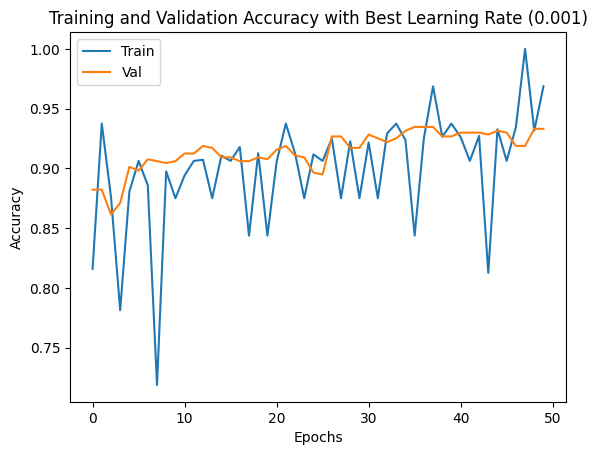

In [8]:
# Imprimir los resultados y generar la gráfica
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Val')
plt.title(f'Training and Validation Accuracy with Best Learning Rate ({best_lr})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### UTILIZANDO EL MODELO EN EL ANALISIS DE 1 IMAGEN

In [ ]:
# Probando el Modelo con 1 Imagen
# Cargar la imagen
imagen_a_analizar = cv2.imread('/kaggle/input/propio/Prueba03.jpg', cv2.IMREAD_COLOR)
imagen_a_analizar = cv2.resize(imagen_a_analizar, (150, 150))
imagen_a_analizar = imagen_a_analizar / 255.0
imagen_a_analizar = np.expand_dims(imagen_a_analizar, axis=0)  # Agregar la dimensión del lote

# Realizar la predicción
predicciones = model.predict(imagen_a_analizar)

# Obtener la clase con la probabilidad más alta
indice_clase_predicha = np.argmax(predicciones)

# Obtener el nombre de la clase
nombre_clase_predicha = label_encoder.inverse_transform([indice_clase_predicha])[0]

# Imprimir el nombre de la clase predicha
print("Clase predicha:", nombre_clase_predicha)
print("Prueba hecha con imagenes de internet aleatoriamente")

# Mostrar la imagen original redimensionada junto con la clase predicha
imagen_a_analizar = cv2.imread('/kaggle/input/propio/Prueba03.jpg', cv2.IMREAD_COLOR)
plt.title(f"Clase predicha: {nombre_clase_predicha}")
plt.imshow(cv2.cvtColor(imagen_a_analizar, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()